# Lab 6 - Visualization & Machine Learning

Last update: 11/11/2023

- Name: Nguyễn Thị Minh Minh
- Student ID: 21127528

***

In [1]:
# visialize stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import json
# !pip install geopandas
import geopandas as gpd

# modeling stuff
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random

import itertools

## Data visualization

- In this section, you are going to compute and visualize some information about Covid-19
- The data prepared in `./data` was collected from Worldometer
- Link: https://www.worldometers.info/coronavirus/

In [2]:
# read the data into a dataframe
df = pd.read_csv('./data/data.csv')
print(f'Shape: {df.shape}')
df.head(5)

Shape: (219, 10)


,Country Name,Total Cases,New Cases,Total Deaths,New Deaths,Total Recovered,Active Cases,Critical Cases,Total Tests,Population
0,USA,"31,990,143",NaN,"576,298",NaN,"24,560,856","6,852,989","9,321","420,822,699","332,516,170"
1,India,"13,689,453","+3,380","171,089",NaN,"12,253,697","1,264,667","8,944","259,207,108","1,390,568,032"
2,Brazil,"13,521,409",NaN,"355,031",NaN,"11,957,068","1,209,310","8,318","28,600,000","213,737,070"
3,France,"5,067,216",NaN,"99,135",NaN,"310,934","4,657,147","5,916","70,140,847","65,386,285"
4,Russia,"4,657,883","+8,173","103,601",338.0,"4,281,776","272,506","2,300","124,100,000","145,983,351"


### Requrement #1: Preprocess

- **TODO**: Take a look at the data files, then go to the URL aforementioned, explore the meaning of columns in the dataset and fill in the blanks:
    - Country Name: This column is listed out the name of all countries to be reported about the coronavirus cases worldwide.
    - Total Cases: This column shows the total number of COVID - 19 confirmed by the country since the start of pandemic till now.
    - New Cases: The column illustrates the number of COVID-19 cases collected within the current day.
    - Total Deaths: The column indicates the total number of deaths due to COVID-19 since the first date of pandemic till now.  
    - New Deaths: This represents the new deaths case within the current day reported by the countries.
    - Total Recovered: This column shows the total number of people who have infected COVID-19 and recovered since the start of pandemic.
    - Active Cases: Active cases column indicates the current number of patients that are still infected with COVID-19 and have not recovered yet. This could be considered calculates as **Total Cases - Total Recovered - Total Deaths**
    - Critical Cases: The column shows the number of cases that is reported as especially dangerous; putting patients at risk leading to deaths or severe sequela. This will reflects the situation needing to be treated in hospital urgently.
    - Total Tests: This column shows the total number of COVID-19 test conducted in each country so that people could make an objective assess over the effectiveness of keeping the pandemic under control.
    - Population: The column lists the population of each country correspondingly.

- Check the data with `info()` function

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    object 
 2   New Cases        46 non-null     object 
 3   Total Deaths     219 non-null    object 
 4   New Deaths       32 non-null     float64
 5   Total Recovered  217 non-null    object 
 6   Active Cases     217 non-null    object 
 7   Critical Cases   146 non-null    object 
 8   Total Tests      210 non-null    object 
 9   Population       219 non-null    object 
dtypes: float64(1), object(9)
memory usage: 17.2+ KB


- You can see that `New Cases`, `New Deaths`, `Critical Cases` have a lot of missing data (at least 33.3%). Therefore, we have to remove these columns.
- Most of data in columns are `object` type, which are not suitable at all. They should be converted to integer.
- `Total Recovered`, `Active Cases` and `Total Tests` only have a few missing values, so we can fill in these missing values with median value of each column.

In [4]:
# TODO: drop New Cases, New Deaths, Critical Cases
# raise NotImplementedError('not implemented')

df.drop(['New Cases', 'New Deaths', 'Critical Cases'], axis=1, inplace=True)
# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country Name     219 non-null    object
 1   Total Cases      219 non-null    object
 2   Total Deaths     219 non-null    object
 3   Total Recovered  217 non-null    object
 4   Active Cases     217 non-null    object
 5   Total Tests      210 non-null    object
 6   Population       219 non-null    object
dtypes: object(7)
memory usage: 12.1+ KB


In [5]:
# TODO: convert data to integer. if the converter returns error, leave it a None
for col in df.columns:
    if col == 'Country Name':
        continue
    if df[col].dtype == 'object' and df[col].str.contains(',').any():
        df[col] = df[col].str.replace(',', '')
    df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int32  
 2   Total Deaths     204 non-null    float64
 3   Total Recovered  217 non-null    float64
 4   Active Cases     217 non-null    float64
 5   Total Tests      210 non-null    float64
 6   Population       219 non-null    int32  
dtypes: float64(4), int32(2), object(1)
memory usage: 10.4+ KB


**TODO**: We did handle missing value before. Why do we still have missing values here?

Actually, in the previous step, we haven't handled all missing values yet. We just drop the data columns with large percent of mising values. I suppose we will handle all of missing values in the next steps.

In [6]:
# TODO: fill in the missing data with median value
# raise NotImplementedError('not implemented')
for col in df.columns:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)
# check the result
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country Name     219 non-null    object 
 1   Total Cases      219 non-null    int32  
 2   Total Deaths     219 non-null    float64
 3   Total Recovered  219 non-null    float64
 4   Active Cases     219 non-null    float64
 5   Total Tests      219 non-null    float64
 6   Population       219 non-null    int32  
dtypes: float64(4), int32(2), object(1)
memory usage: 10.4+ KB


**TODO**: Why do we have `float64` here?

Because in the cell downcast to **Integer** above, I use **errors: 'coerce'**. So that, in the missing values position, it will turn into **NaN** value. However, **NaN** is a float type, so it will upcast all values to **float64** in the column. 

In [7]:
# TODO: save your new data frame to `./data/new_data.csv`
# raise NotImplementedError('not implemented')
df.to_csv('./data/new_data.csv', index=False)

In [8]:
# TEST
file = open('./data/new_data.csv', 'r')
new_data = file.read()
file.close()

file = open('./data/correct_data.csv', 'r')
correct_data = file.read()
file.close()

assert new_data == correct_data

### Requirement #2: Visualize single variable

- For now, if you do not pass the test, you have to work on the correct file by un-commenting the cell code below to read the `./data/correct_data.csv` into `df`
- You are going to draw 6 bar charts which show all the fields of dataset. For each bar chart, sort the values of countries in descending order and only visualize 5 countries

In [9]:
# # un-comment these lines of code
# df = pd.read_csv('./data/correct_data.csv')

df.head()

,Country Name,Total Cases,Total Deaths,Total Recovered,Active Cases,Total Tests,Population
0,USA,31990143,576298.0,24560856.0,6852989.0,420822699.0,332516170
1,India,13689453,171089.0,12253697.0,1264667.0,259207108.0,1390568032
2,Brazil,13521409,355031.0,11957068.0,1209310.0,28600000.0,213737070
3,France,5067216,99135.0,310934.0,4657147.0,70140847.0,65386285
4,Russia,4657883,103601.0,4281776.0,272506.0,124100000.0,145983351


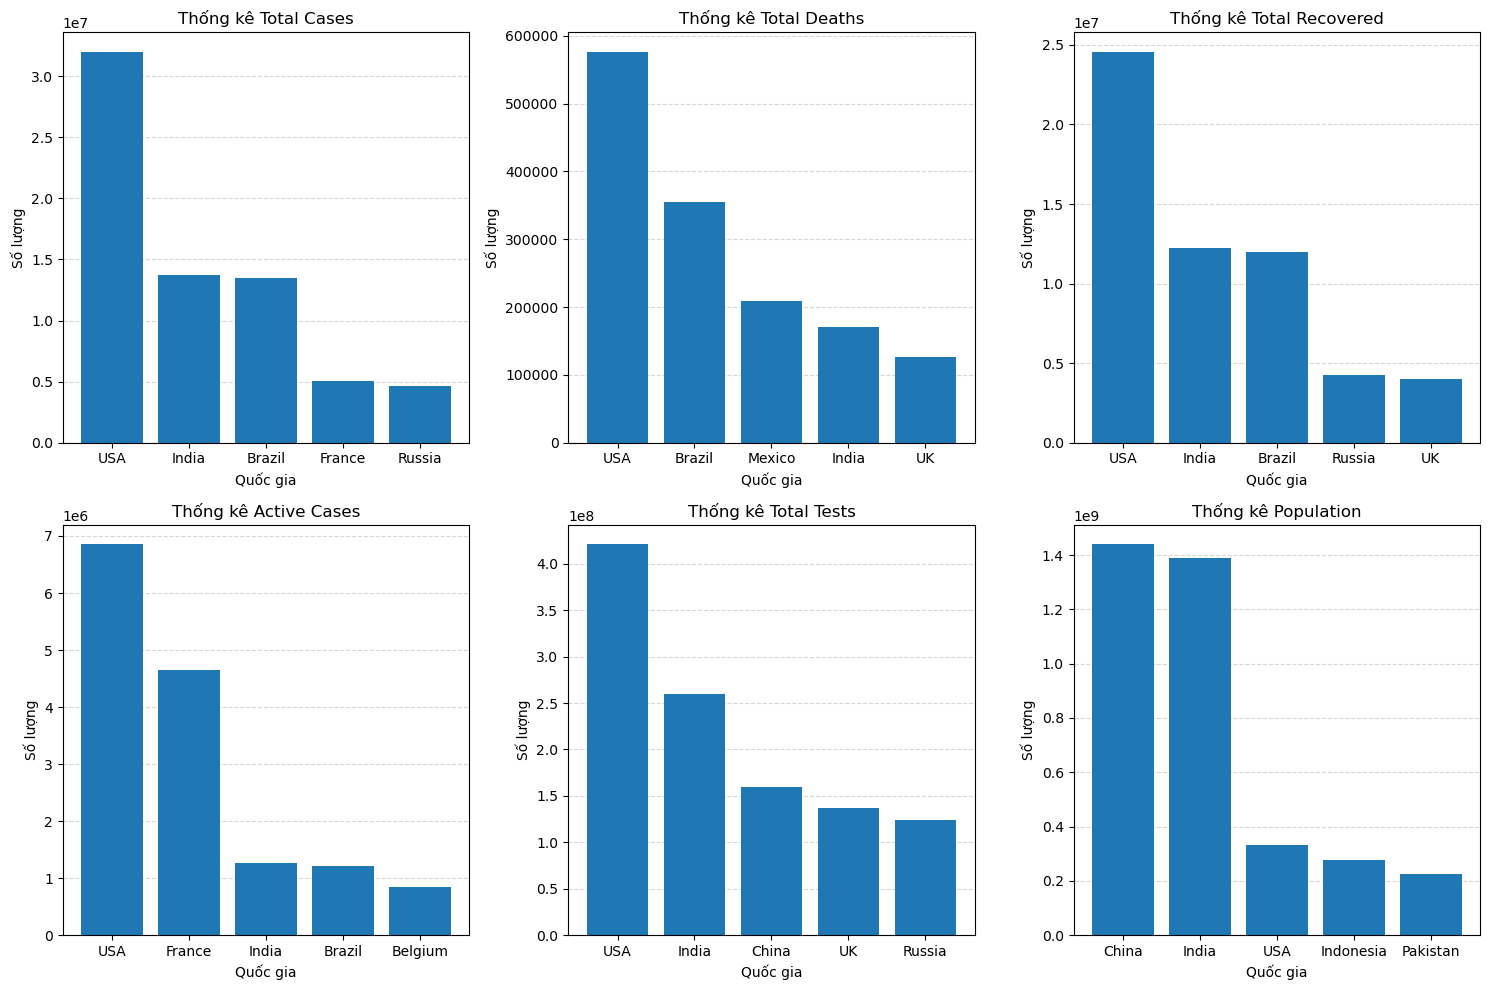

In [10]:
# TODO: draw 6 bar charts
# raise NotImplementedError('not implemented')

sorted_total_cases = df.sort_values('Total Cases', ascending=False)
countries_total_cases, total_cases = sorted_total_cases.head(5)['Country Name'].tolist(), sorted_total_cases.head(5)['Total Cases'].tolist()

sorted_total_deaths = df.sort_values('Total Deaths', ascending=False)
countries_total_deaths, total_deaths = sorted_total_deaths.head(5)['Country Name'].tolist(), sorted_total_deaths.head(5)['Total Deaths'].tolist()

sorted_total_recovered = df.sort_values('Total Recovered', ascending=False)
countries_total_recovered, total_recovered = sorted_total_recovered.head(5)['Country Name'].tolist(), sorted_total_recovered.head(5)['Total Recovered'].tolist()

sorted_active_cases = df.sort_values('Active Cases', ascending=False)
countries_active_cases, active_cases = sorted_active_cases.head(5)['Country Name'].tolist(), sorted_active_cases.head(5)['Active Cases'].tolist()

sorted_total_tests = df.sort_values('Total Tests', ascending=False)
countries_total_tests, total_tests = sorted_total_tests.head(5)['Country Name'].tolist(), sorted_total_tests.head(5)['Total Tests'].tolist()

sorted_population = df.sort_values('Population', ascending=False)
countries_population, population = sorted_population.head(5)['Country Name'].tolist(), sorted_population.head(5)['Population'].tolist()

fig, axs = plt.subplots(2,3, figsize = (15,10))

data_x = [countries_total_cases, countries_total_deaths, countries_total_recovered, countries_active_cases, countries_total_tests, countries_population]
data_y = [total_cases, total_deaths, total_recovered, active_cases, total_tests, population]
titles = ['Total Cases', 'Total Deaths', 'Total Recovered', 'Active Cases', 'Total Tests', 'Population']


for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)
    ax.set_xlabel('Quốc gia')
    ax.set_ylabel('Số lượng')
    ax.set_title(f'Thống kê {titles[i]}')
    x_val = list(range(len(data_x[i])))
    ax.bar(x_val, data_y[i])
    ax.set_xticks(x_val)
    ax.set_xticklabels(data_x[i])

plt.tight_layout()
plt.show()

**TODO**: Comment about the chart

* A glance at 6 bar charts, **USA** is almost seen in all criteria involving COVID-19, being top list in all excepts for **Population**. 
* In the statistics, the US is almost at the top with figures nearly double those of the countries in second place. In terms of **Total cases**, the US leads with nearly 32 million cases, however, India is in second place with over 13.5 million cases. In addition, Brazil also has a very alarming number of infections with a total number of cases nearly equal to India. In 4th and 5th place are France and Russia with over 5 million cases and 4.6 million cases, respectively. A common point of these countries is that they have a large population, so controlling the epidemic is a challenge, leading to a high number of COVID-19 infections. However, a special point is China, with the largest population in the world, the total number of infections is quite modest compared to the population. This can be explained by the strict control of the epidemic from the government with many strong lockdown measures. 
* Considering **Death Cases**, almost all countries in the top 5 with the most infections are also in the top countries with the highest number of deaths, including: the US, Brazil, India. The highest number of deaths belongs to the US with nearly 600,000 cases; Brazil with over 355,000 cases and India with 171,000 cases. In addition, the top 5 also includes Mexico and the UK, especially Mexico. The high number of deaths indicates the overload of the health systems of these countries at that time, there were too many patients leading to insufficient health care, which could be the cause of the disease progressing more severely and causing death. In addition, it also reflects that the people of these countries are not in good health conditions with many underlying diseases, so COVID-19 easily causes patients with many severe symptoms and causes death.
* **Recovered Cases** witnesses those familiar nations with high total cases. This is also a good signal.
* **Active Cases**, however, is still quite high. USA top the list with nearly 7 million cases. Top 5 also see an incredible upsurge of pandemic coming from France. It is also understandable that due to the fact that those countries loose their policy against COVID-19. This is not totally a bad policy, but an active move in the new era of living with the pandemic.
* Concerning **Total Tests**, besides those familiar mentioned countries, China despite of having quite low cases in total, the country conducted a large amount of testing to prevent pandemic. At first, the strategy seems to be effective, preventing the country from collapsing the medical system. However, in the long run, it requires a large money investing in test kits, testing for the whole residents every 2 or 3 days is quite wasting, impossible for a long plan due to the incoming shortage of medical resources.
* Data currently being analyzed seems to be not updated to the present, the total number of infections so far has exceeded 771 million cases worldwide, but thanks to vaccines and treatments, the epidemic is somewhat less tense than the situation 3 years ago.

### Requirement #3: Draw world map

- Using bar chart just gives you a little bit information about numbers
- In this requirement, you are going to draw a world map with circles which shows the number of cases for each country. Specifically, you are provided a file named `coord.json` that contains longitude and latitude of each country. You are going to use `Total cases` and `Total Death` to draw the following charts

C:\Users\Hp\AppData\Local\Temp\ipykernel_8792\1937949328.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


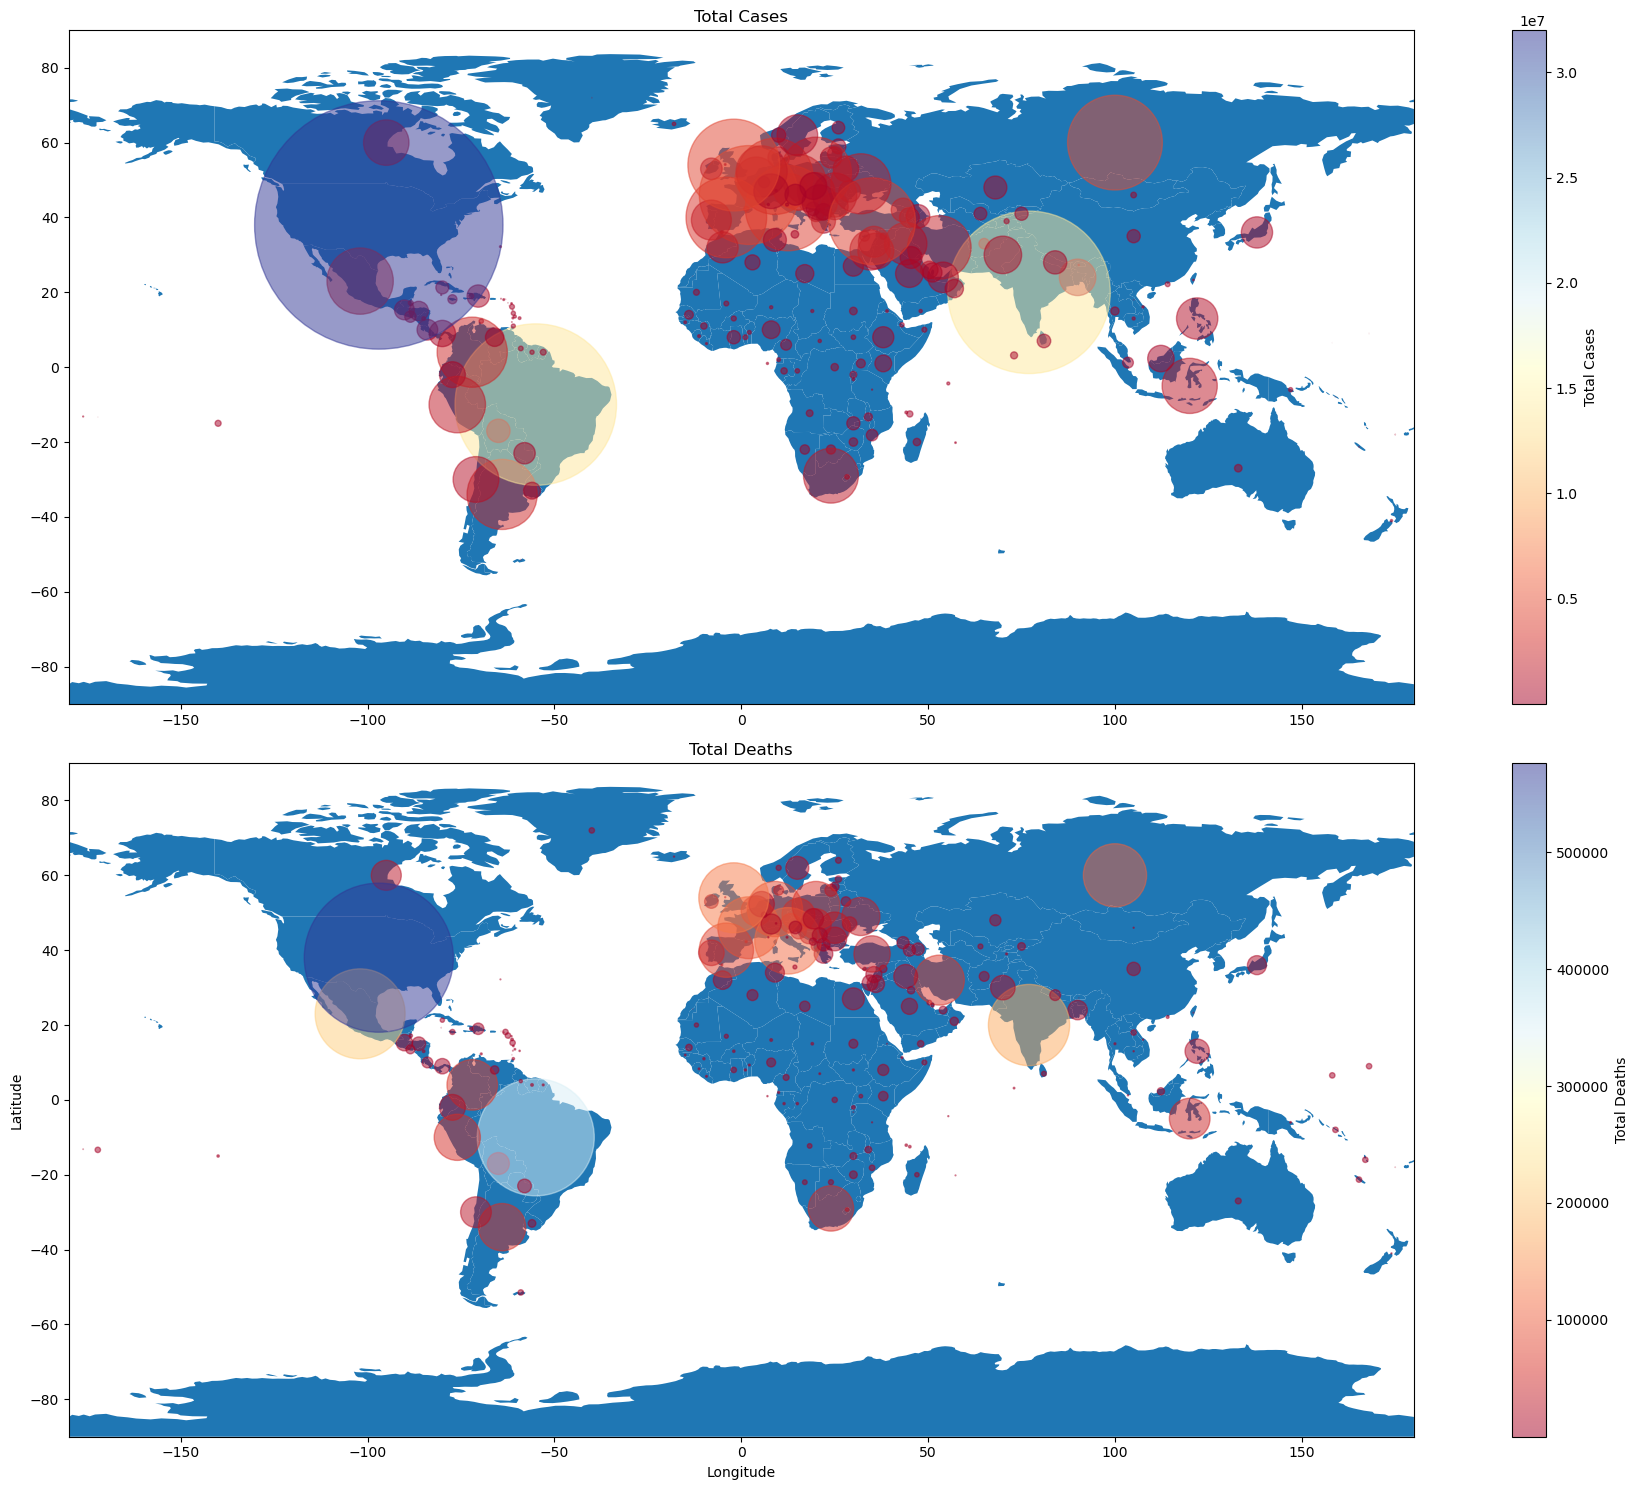

In [11]:
# TODO: draw 2 world map chart using geopandas
# raise NotImplementedError('not implemented')
with open("data/coord.json") as geoFile:
    coordinate = json.load(geoFile)

coordinate = pd.DataFrame(coordinate)
coordinate_cases_deaths = pd.merge(coordinate, df[['Country Name','Total Cases','Total Deaths']], right_on='Country Name', left_index=True, how='inner').reset_index(drop=True)

#Draw world map
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, axs = plt.subplots(2,1, figsize=(20,15))
worldmap.plot(ax=axs[0])
worldmap.plot(ax=axs[1])

x = coordinate_cases_deaths['long']
y = coordinate_cases_deaths['lat']
data_scatter = [coordinate_cases_deaths['Total Cases'], coordinate_cases_deaths['Total Deaths']]

map_titles = ['Total Cases', 'Total Deaths']
size_marker = [coordinate_cases_deaths['Total Cases']/1000,coordinate_cases_deaths['Total Deaths']/50]

for i, ax in enumerate(axs.flatten()):
    ax.set_title(map_titles[i])
    scatter = ax.scatter(x,y, c=data_scatter[i], cmap='RdYlBu', alpha=0.5, s=size_marker[i])
    ax.set_xlim([-180,180])
    ax.set_ylim([-90,90])

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total Cases' if i == 0 else 'Total Deaths')

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


**TODO**: Comment about the chart

* From the drawn map, we observe that the 2 continents that is most affected by COVID-19 are the America and Europe, in both total cases and total deaths. The countries in America, including the United States, Canada, Mexico, and Brazil, all had alarming pandemic situations.
* In the European region, the pandemic situation occurred in almost all countries with a large scale and number. This region also has the highest density of COVID-19 cases and death cases compared to the rest of the world.

* In Asia, India was the country with the most recorded infections at that time. As can be seen in the figure, the circle in the India area is quite large, only behind North America (USA) and Brazil, and higher than the total number of infections/deaths compared to countries in Europe.
* In addition, in Southeast Asia, Philippines and Indonesia are the two countries with modest areas, but the data shows that the pandemic here is also quite complicated compared to other countries in the region. However, in China, it can be seen that the pandemic is still under control with a modest number of infections/deaths compared to the total population and the area of the country. The data somewhat reflects the ability to control the pandemic through the policies of the countries.
* In the African region, COVID-19 is present in almost all countries, but the most prominent is South Africa with a high total number of infections/deaths.

### Requirement #4: Relationship between 2 variables

- Exploring the relationship between variables is a needed task to do
- You will start with exploring the linear relationship between 2 variables. In order to do so, draw $C_6^2=15$ scatter plots. For each plot, draw a line that shows the linear relationship of variables. You should implement the line yourself instead of using library.

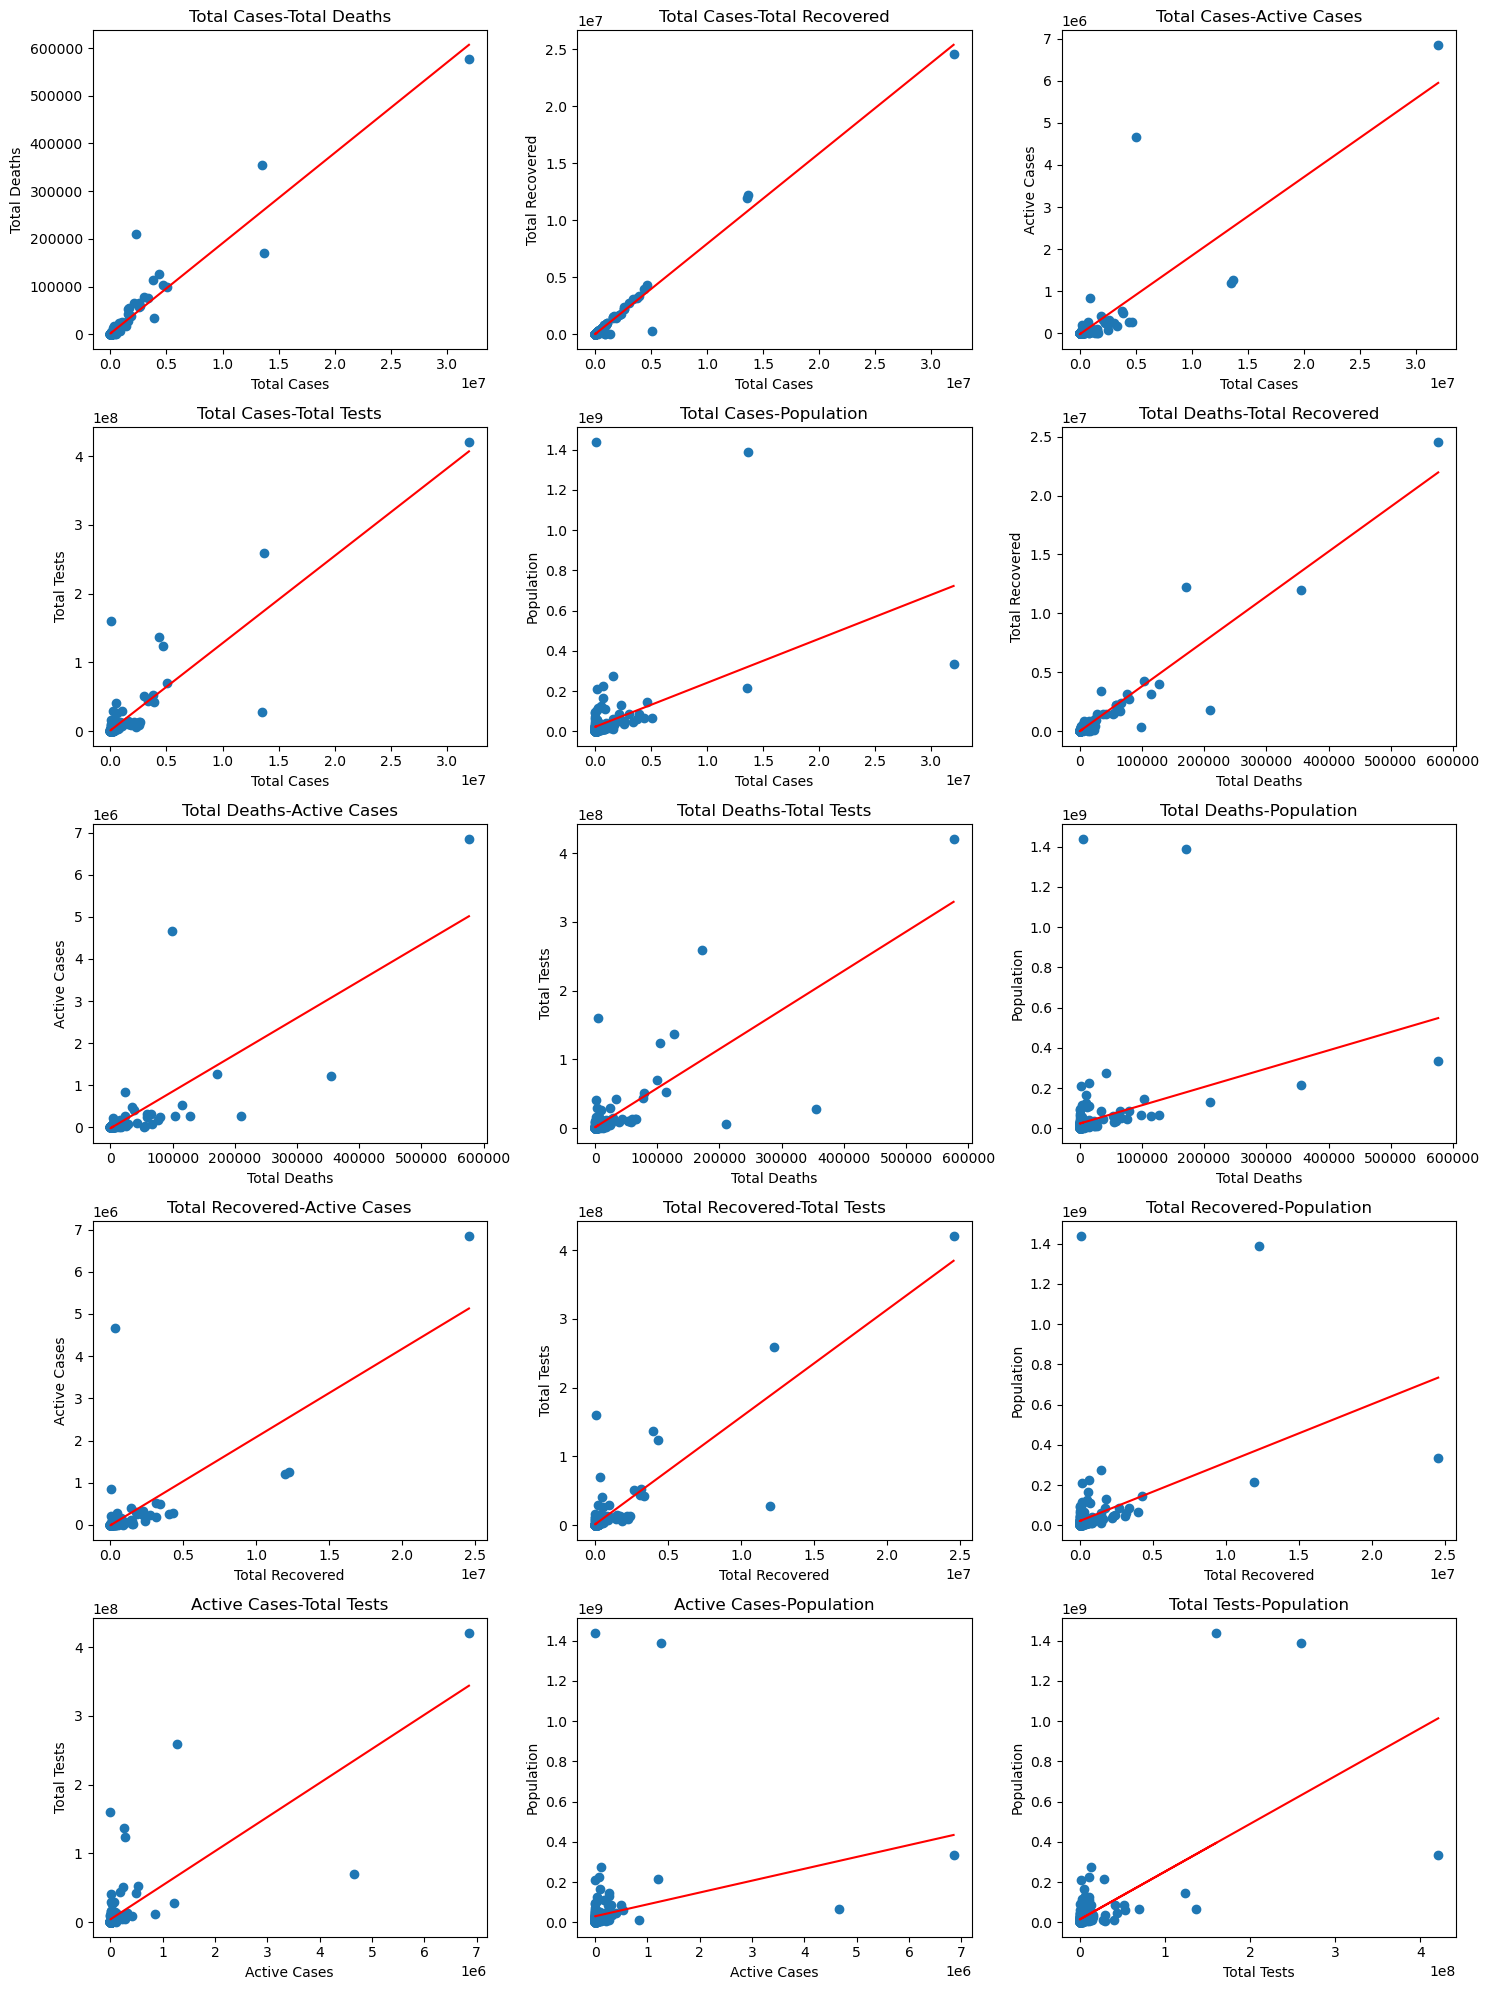

In [12]:
# TODO: scatter stuff
# raise NotImplementedError('not implemented')

def cal_linear_function(x, y):
    N = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_x_squared = sum(i**2 for i in x)
    sum_xy = sum(i*j for i, j in zip(x, y))

    a = (N * sum_xy - sum_x * sum_y) / (N * sum_x_squared - sum_x**2)
    b = (sum_y - a * sum_x) / N

    return a, b

figure, axs = plt.subplots(5,3, figsize=(15,20))
data_pair = list(itertools.combinations(df.columns[1:], 2))

for i, ax in enumerate(axs.flatten()):
    x = df[data_pair[i][0]]
    y = df[data_pair[i][1]]
    ax.scatter(x,y)
    ax.set_xlabel(data_pair[i][0])
    ax.set_ylabel(data_pair[i][1])

    a, b = cal_linear_function(x, y)
    ax.plot(x, a * x + b, color='red')
    

    ax.set_title(f'{data_pair[i][0]}-{data_pair[i][1]}')

plt.tight_layout()
plt.show()


**TODO**: As showed above, give your prediction about the relationship between each pair.

* Through the 15 scatter plots drawn, it can be seen that all the lines trend upwards from left to right. This indicates `a positive relationship among 15 pairs of variables`, meaning that when one variable increases, the other also increases. However, the strength of these relationships is somewhat reflected in the slope of the line. Variables with a tight relationship usually have a line with a slope close to 45 degrees, including **Total Cases- Total Deaths**, **Total Cases- Total Recovered**, **Total Cases- Active Cases**, **Total Cases- Total Tests**, **Total Deaths- Total Recovered**, **Total Recovered- Total Tests**, **Total Recovered- Total Tests**. Based on this slope, I predict that the correlation coefficient of the above relationships will be close to `1 (> 0.6)`. I expect the correlation index among the remaining group would be `less than 0.6`.
* Regarding the points on the scatter plots, I observe that in the first two figures **Total Cases- Total Deaths**, **Total Cases- Total Recovered** and  **Total Deaths - Total Recovered**, the points are mostly on or near the line, indicating that they follow the predicted linear function model. Meanwhile, in most of the remaining models, the points tend to cluster near the origin (O). These clusters represent a group of countries with relatively small variable values compared to other countries. In this group of models, there are outliers quite far from the linear line, indicating that the country corresponding to that outlier does not follow the rule that the linear line has drawn. 

### Requirement #5: Double check the relationship between 2 variables

- In order to make sure about the linear relationship, you have to check each pair with **Pearson correlation coefficient**
- Specifically, $\rho$ is calculated as follows:

$$\rho_{X, Y} = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

- Then, plot these 15 values using heatmap

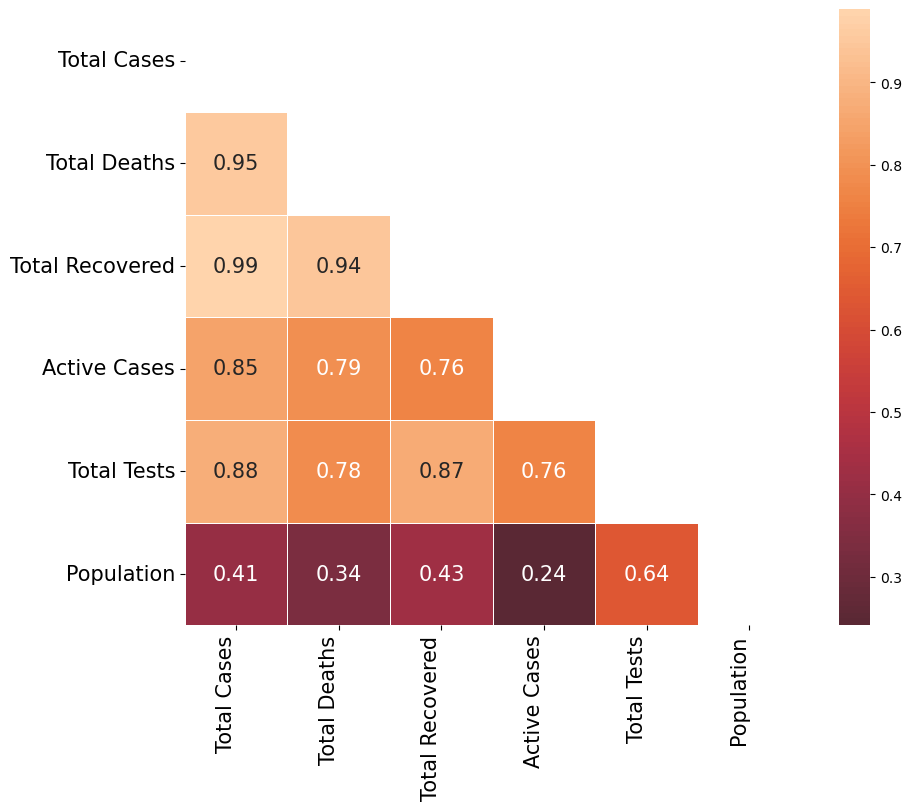

In [13]:
# TODO: create heatmap
# raise NotImplementedError('not implemented')

plt.figure(figsize=(10,8))
df_corr = df.drop('Country Name', axis=1).corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))

corr_hm = sn.heatmap(df_corr, mask = mask,center = 0, annot = True, square = True, linewidths = .5, annot_kws = {'size': 15})
corr_hm.set_xticklabels(corr_hm.get_xticklabels(), rotation = 90, horizontalalignment = 'right', fontsize = 15)
corr_hm.set_yticklabels(corr_hm.get_yticklabels(), rotation = 0, horizontalalignment = 'right', fontsize = 15)
plt.show()


For now, you can check whether your prediction is right or wrong!

## Model visualization

- In this section, we are going to visualize the training and testing process of machine learning model
- The process of training and testing a model is as follow:
    1. Prepare data for training and testing
    2. Create a model
    3. Train and test the model
    4. Visualize the result

- You are required to:
    1. Study Multi-layer neural network and Convolutional neural network
    2. Study `Pytorch` in order to prepare data and design machine learning model
    3. Design 2 models to classify MNIST dataset. Then, visualize the result of each model and compare the result to each other
        - Model 1: A fully-connected model with 4 layers. The input layer has $784$ neurons. The hidden layer #1 has $1024$ neurons, which is followed by a $ReLU$ as activation functions. The hidden layer #2 has $512$ neurons, also followed by a $ReLU$ as activation functions. The output layer has $10$ neurons (of course), which follows by a $LogSoftmax$ function
        - Model 2: A CNN model with 2 Convolution layers and 1 linear layer. All the CNN layers have 20 filters, kernel size equal to $5$. Each of them is followed by a $ReLU$ activation function and a MaxPooling2D layer ($kernel\_size=2$). The linear layer is followed by a $LogSoftmax$ activation function

- Google Colab can be used since it provides free GPU, which makes your training and testing process faster

### Requirement #6: Prepare data

- `Pytorch` supports a lot of datasets for running machine learning model. In this lab, we use MNIST dataset. So, download the training set and the testing set using `Pytorch` and store them in `./data`
- Note that you have to transform your data into `tensor` (a datatype that's quite similar to `numpy array`) so you can input to model
- After that, create `train_dataloader` and `test_dataloader`

**TODO**: Explain why we have to create dataloader

* Because, when downloading the dataset, It includes both features and labels: features are input for training and testing and labels are the results (output) of the model. Therefore, to simplify this issue, we use `DataLoader` to prepair our data for our data processing with machine learning. 

In [14]:
# TODO: download training, testing data and store them into training_data and testing_data
# Then, create train_dataloader and test_dataloader with batch_size=32
# raise NotImplementedError('not implemented')

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)



In [15]:
train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(testing_data, batch_size=32)

- After downloading the data, visualize 10 random samples (2 rows, 5 samples for each row) from training set.

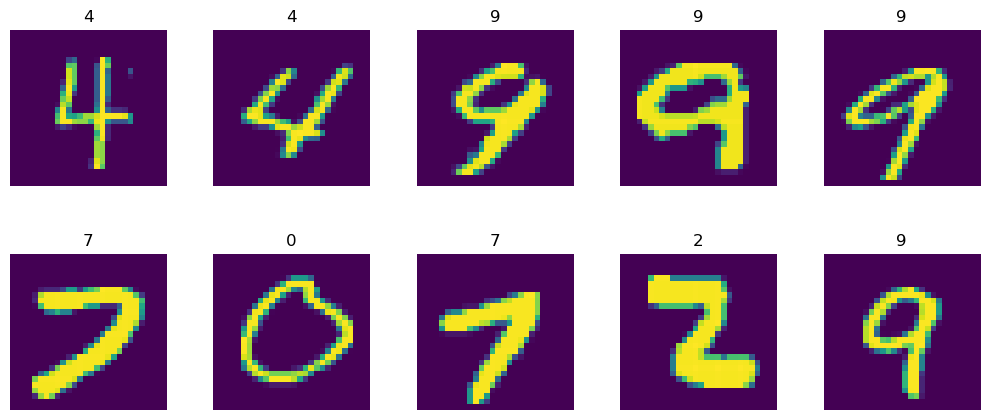

In [16]:
# TODO: visualize 10 random samples
# raise NotImplementedError('not implemented')
random_indices = random.sample(range(len(training_data)),10)
fig, axs = plt.subplots(2,5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(training_data[random_indices[i]][0].squeeze())
    label = training_data[random_indices[i]][1]
    plt.setp(ax, title=f'{label}')
    ax.axis('off')
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=-0.7)
plt.show()

### Requirement #7: Create models

- Create 2 models as mentioned above. Call them `Mnist_FC` and `Mnist_CNN`
- **I strongly recommend that you should slowly implement, print out the output and its shape of each layer in order to get a deep understanding of what you are trying to do**
- Before moving to the next requirement, you should test your model with a random sample of the dataset. In case you create code cells for testing, remember to remove these cells

A CNN model with 2 Convolution layers and 1 linear layer. All the CNN layers have 20 filters, kernel size equal to $5$. Each of them is followed by a $ReLU$ activation function and a MaxPooling2D layer ($kernel\_size=2$). The linear layer is followed by a $LogSoftmax$ activation function


In [17]:
# TODO: create Mnist_FC and Mnist_CNN
# raise NotImplementedError('not implemented')

class Mnist_FC(nn.Module):
    def __init__(self):
        super(Mnist_FC, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_process = nn.Sequential(
            nn.Linear(784, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc_process(x)

class Mnist_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.cnn_process = nn.Sequential(
            nn.Conv2d(1,20, kernel_size = 5), # 1: 'grey scale'
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Conv2d(20,20, kernel_size = 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2),

            nn.Flatten(),
            nn.Linear(320, 10), # 320 = 20*4*4
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, x):
        return self.cnn_process(x)

    

### Requirement #8: Train and test models

- Design `train` and `test` function with the parameters provided in the following code cell
    - `train` function trains the model with all the data in training set
    - `test` function tests the model with all data in testing set

- Return the accuracy (e.g. $0.847351$) after training and testing

**TODO**: Explain the parameters of `train` and `test` function. In `test` function, there is a line of code that says `with torch.no_grad()`. Why do we have this line of code?

* Those parameters are served for the training and testing process.
    * In training process: The purpose of this stage is to adjust the **weight** so that the loss could be reduced to much close to 0. 
        * `dataloader` is used to get the train dataset prepared before to compute the prediction and loss.
        * `model` is the parameters used for taking the defined class above to predict output of model.
        * `loss_fn` is the parameters that is defined to calculate the loss value before moving to optimization to upgrade weights.
        * `optimizer` is to adjust the weight base loss found by loss_fn at the previous step.
    * In testing process: `dataloader` is the testing dataset prepared before and `model` is the class designed to predict the result (label) from test set (image). 

* `with torch.no_grad`: Because by default, the `requires_grad=True` will do the job of tracking computational history together with gradient computation. But in test function, we dont need to update weight, just to check the accuracy ratio so by adding `with torch.no_grad`, we could turn off those mentioned features, hence saving memory and boosting the computational speed.
    

In [18]:
# TODO: design train and test function

# check gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} for training and testing')

def train(dataloader, model, loss_fn, optimizer):
    # raise NotImplementedError('not implemented')
    size = len(dataloader.dataset)
    correct_num = 0
    for feature, label in (dataloader):
        feature, label = feature.to(device), label.to(device)

        pred = model(feature)
        loss = loss_fn(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct_num += (pred.argmax(1) == label).type(torch.float).sum().item()
    return correct_num / size



def test(dataloader, model):
    # raise NotImplementedError('not implemented')
    size = len(dataloader.dataset)
    correct_num = 0

    with torch.no_grad():
        for feature, label in dataloader:
            pred = model(feature.to(device))
            correct_num += (pred.argmax(1) == label).type(torch.float).sum().item()
    return correct_num / size

Using cpu for training and testing


- Run 20 epochs for each model. In order to do so, at fist, you have to define `learning_rate, loss_fn` and `optimizer`. I will help you on that

- Save the history of training and testing process as `history_fc` and `history_cnn`. During the running process, you should print out the accuracy in order to keep track

- The history is a dictionary with the following structure:

```python
history = {
    1: [0.6, 0.5], # the key (type: int) is the epoch
    2: [0.7, 0.6], # the value (type: list) contains the accuracy of training and testing process at the corresponding epoch
    ...
}
```

**TODO**: List out some loss functions and optimizers that you have heard about

* I have chance of working some loss function:
    * Mean Squared Error - MSE
        $$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_{i} - \hat{Y}_{i})^{2}$$
    * Mean Absolute Error - MAE
        $$MAE = \frac{1}{n} \sum_{i=1}^{n} |Y_{i} - \hat{Y}_{i}|$$
    * Mean Bias Error - MBE
        $$MBE = \frac{1}{n} \sum_{i=1}^{n} (Y_{i} - \hat{Y}_{i})$$
* Some optimizer I have heard about:
    * Gradient Descent
        $$\theta = \theta - \eta \cdot \nabla_{\theta} J(\theta)$$
    * Momentum
        $$v = \gamma v + \eta \nabla_{\theta} J(\theta)$$
        $$\theta = \theta - v$$
    * Stochastic Gradient Descent (SGD)
        $$\theta_{t+1} = \theta_t - \eta \nabla_{\theta} J(\theta_t, x_{(i)}, y_{(i)})$$
    * Mini- Batch Gradient Descent
        $$\theta_{t+1} = \theta_t - \eta \nabla_{\theta} J(\theta_t, X_{(i:i+n)}, Y_{(i:i+n)})$$

In [19]:
model_fc = Mnist_FC()
model_cnn = Mnist_CNN()

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer_fc = torch.optim.SGD(model_fc.parameters(), lr=learning_rate)
optimizer_cnn = torch.optim.SGD(model_cnn.parameters(), lr=learning_rate)

# TODO: run 20 epochs for Mnist_FC and Mnist_CNN
# raise NotImplementedError('not implemented')
def test_epochs(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs):
    history = {}
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}\n----------------------------')
        acc_train = train(train_dataloader, model, loss_fn, optimizer)
        acc_test = test(test_dataloader, model)
        print(f'Training accuracy: {acc_train:.4f}')
        print(f'Testing accuracy : {acc_test:.4f}')
        history[epoch] = [acc_train, acc_test]
    return history

history_fc = test_epochs(model_fc, train_dataloader, test_dataloader, loss_fn, optimizer_fc, 20)
history_cnn = test_epochs(model_cnn, train_dataloader, test_dataloader, loss_fn, optimizer_cnn, 20)


Epoch 1
----------------------------
Training accuracy: 0.4365
Testing accuracy : 0.6424

Epoch 2
----------------------------
Training accuracy: 0.6733
Testing accuracy : 0.6961

Epoch 3
----------------------------
Training accuracy: 0.7225
Testing accuracy : 0.7683

Epoch 4
----------------------------
Training accuracy: 0.7951
Testing accuracy : 0.8226

Epoch 5
----------------------------
Training accuracy: 0.8332
Testing accuracy : 0.8504

Epoch 6
----------------------------
Training accuracy: 0.8542
Testing accuracy : 0.8679

Epoch 7
----------------------------
Training accuracy: 0.8689
Testing accuracy : 0.8796

Epoch 8
----------------------------
Training accuracy: 0.8782
Testing accuracy : 0.8873

Epoch 9
----------------------------
Training accuracy: 0.8841
Testing accuracy : 0.8920

Epoch 10
----------------------------
Training accuracy: 0.8891
Testing accuracy : 0.8958

Epoch 11
----------------------------
Training accuracy: 0.8937
Testing accuracy : 0.8984

Epoch 1

### Requirement #9: Visualize

- Produce a graph as the following code cell and comment about the running process of 2 models

**TODO**: Your comment
* Overall, I assess `CNN network is a better model than FC network`. And both models are making good progress in learning to classify items with certain stability.
* Now, I would give more insight to each model:
    * In terms of `Fully Connected Network`, the trends of the training and testing accuracy lines are both upward over time. This indicates that the model is learning from the training process quite well and has the possibility of labeling unseen items. This is a good sign, thus more training could lead to better improvement. From the part of 2.5 - 7.5, the training and testing lines seem to overlap, which seems to be a good signal for not overfitting but at a quite modest rate, about 0.75 - 0.88. After 7.5, the 2 lines have the tendency of convergence,but still have a very tiny gap between them; this would be a good signal for our model when coming to unseen data.
    * Regarding the `CNN network`, the patterns of the two lines look quite alike and in a good term. The learning ability improves over time as the lines are seen going upward at a speedy pace at the phase from 0 - 2.5 epochs, afterwards the accuracy of both training and testing exceeds the milestone of 0.9 - a very expected number. And the gap between the two lines only appears at first, before 7.5 epochs, however, the gap is gradually reduced to a very great extent; in other words, the two lines have a tendency of converging. Additionally, the train set and test set are prepared distinctly from each other; hence we could conclude that the CNN network prepared is performing well. The model trained could produce an expected result, giving us a good answer on unseen data.

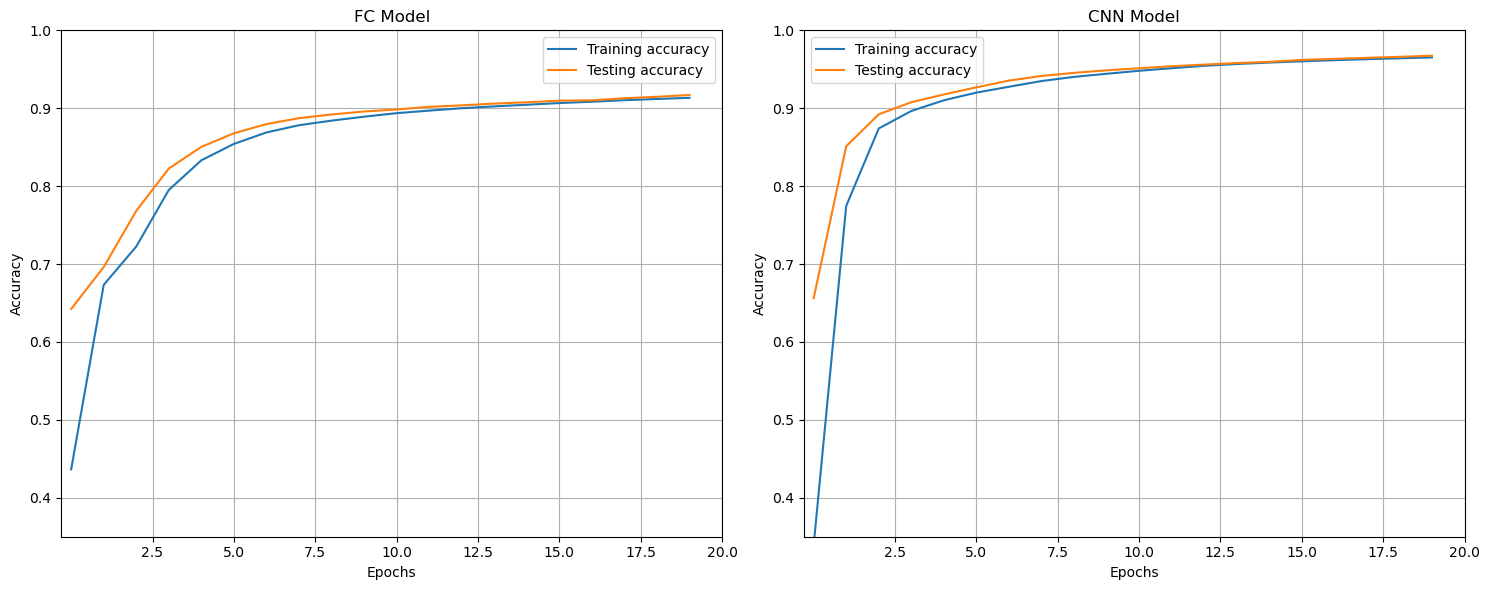

In [20]:
# TODO: visualize the history
# raise NotImplementedError('not implemented')

history_fc_df = pd.DataFrame(history_fc).T
history_cnn_df = pd.DataFrame(history_cnn).T

fig, axs = plt.subplots(1,2, figsize = (15,6))
titles = ['FC Model', 'CNN Model']

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        history = history_fc_df
    else:
        history = history_cnn_df
    ax.plot(history.index, history[0], label='Training accuracy')
    ax.plot(history.index, history[1], label='Testing accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'{titles[i]}')
    ax.grid(True)
    ax.set_xticks(np.arange(2.5, 21, 2.5))
    ax.set_xlim(left = -0.3)
    ax.set_ylim(top = 1, bottom = 0.35)
    ax.legend()
plt.tight_layout()
plt.show()

- Highly recommend you go play around with the parameters of models and re-implement 2 models using `TensorFlow` on Colab